In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import scipy as sc

In [2]:
img_size=(240, 320)
img_channels = 3
batch_size=32

In [3]:
model_name = 'simple_covnet_model.tf'

In [4]:
train_size = 1000
validation_size = 500
test_size = 500

# Load the DataSet

Dataset citation:
- From Semi-Supervised to Transfer Counting of Crowds
C. C. Loy, S. Gong, and T. Xiang
in Proceedings of IEEE International Conference on Computer Vision, pp. 2256-2263, 2013 (ICCV)
- Cumulative Attribute Space for Age and Crowd Density Estimation
K. Chen, S. Gong, T. Xiang, and C. C. Loy
in Proceedings of IEEE Conference on Computer Vision and Pattern Recognition, pp. 2467-2474, 2013 (CVPR, Oral)
- Crowd Counting and Profiling: Methodology and Evaluation
C. C. Loy, K. Chen, S. Gong, T. Xiang
in S. Ali, K. Nishino, D. Manocha, and M. Shah (Eds.), Modeling, Simulation and Visual Analysis of Crowds, Springer, vol. 11, pp. 347-382, 2013
- Feature Mining for Localised Crowd Counting
K. Chen, C. C. Loy, S. Gong, and T. Xiang
British Machine Vision Conference, 2012 (BMVC)

In [5]:
dataset_path = '/Users/olove/Library/CloudStorage/OneDrive-Personal/AI datasets/CrowdCounter'

In [6]:
labels_df = pd.read_csv(dataset_path + '/labels.csv')
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)
labels_df.drop("id", axis=1,inplace=True)
display(labels_df)

,count,image_name
0,35,seq_000001.jpg
1,41,seq_000002.jpg
2,41,seq_000003.jpg
3,44,seq_000004.jpg
4,41,seq_000005.jpg
...,...,...
1995,27,seq_001996.jpg
1996,27,seq_001997.jpg
1997,25,seq_001998.jpg
1998,26,seq_001999.jpg


In [7]:
labels_df = labels_df.sample(frac=1).reset_index(drop=True)
display(labels_df)

,count,image_name
0,33,seq_000746.jpg
1,33,seq_000820.jpg
2,20,seq_001474.jpg
3,42,seq_001015.jpg
4,33,seq_000238.jpg
...,...,...
1995,41,seq_001348.jpg
1996,47,seq_000182.jpg
1997,24,seq_000679.jpg
1998,26,seq_001027.jpg


In [8]:
if (train_size+validation_size+test_size) != len(labels_df):
    print('Dataset size is different from specified class sizes')
    exit(1)

training_df = labels_df[:train_size]
validation_df = labels_df[train_size:train_size+validation_size].reset_index(drop=True)
test_df = labels_df[train_size+validation_size:].reset_index(drop=True)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    
)

x_col_name = 'image_name'
y_col_name = 'count'

train_generator = datagen.flow_from_dataframe(
    training_df, 
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

validation_generator = datagen.flow_from_dataframe(
    validation_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

Found 1000 validated image filenames.
Found 500 validated image filenames.
Found 500 validated image filenames.


# Define the model

In [10]:
inputs = keras.Input(shape= img_size + (img_channels,))

## Custom Simple Covnet

Downsizing using strides instead of MaxPolling in order to conserve location data

In [11]:
#x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
x = layers.Flatten()(x)
# x = layers.Dropout(0.5)(x)

2023-12-10 10:33:56.569745: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-10 10:33:56.569775: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-10 10:33:56.569788: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-10 10:33:56.570045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 10:33:56.570365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Output Layer

In [12]:
outputs = layers.Dense(128, activation="relu")(x)
outputs = layers.Dropout(0.5)(outputs)
outputs = layers.Dense(1)(outputs)

In [13]:
model = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 119, 159, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 79, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 39, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 144768)            0         
                                                                 
 dense (Dense)               (None, 128)               18530432  
                                                                 
 dropout (Dropout)           (None, 128)               0     

# Train model

In [15]:
model.compile(loss="mse", optimizer="adam", metrics=["mae"])
# TODO: Try mae vs accuracy. mae should be better since we are adjusting it to get closer to the actual value

In [16]:
callbacks_list = [
#    keras.callbacks.EarlyStopping(
#        monitor="val_loss", patience=4
#    ),
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        monitor="val_loss",
        save_best_only=True
    ),
    keras.callbacks.TensorBoard()
]

In [17]:
Wsave = model.get_weights()

In [18]:
model.set_weights(Wsave)
history = model.fit(train_generator,
        epochs=300,
        callbacks = callbacks_list,
        validation_data=validation_generator,
)

Epoch 1/300


2023-12-10 10:33:57.343836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 116.5538 - mae: 8.2358INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 5s 150ms/step - loss: 116.5538 - mae: 8.2358 - val_loss: 66.5466 - val_mae: 6.4392
Epoch 2/300
32/32 [==============================] - 4s 126ms/step - loss: 61.1851 - mae: 6.2790 - val_loss: 85.4663 - val_mae: 7.6590
Epoch 3/300
32/32 [==============================] - ETA: 0s - loss: 60.4557 - mae: 6.1640INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 5s 141ms/step - loss: 60.4557 - mae: 6.1640 - val_loss: 33.5882 - val_mae: 4.5054
Epoch 4/300
32/32 [==============================] - ETA: 0s - loss: 35.6645 - mae: 4.7526INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 4s 131ms/step - loss: 35.6645 - mae: 4.7526 - val_loss: 18.7379 - val_mae: 3.4392
Epoch 5/300
32/32 [==============================] - ETA: 0s - loss: 24.1418 - mae: 3.9123INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 4s 132ms/step - loss: 24.1418 - mae: 3.9123 - val_loss: 12.6249 - val_mae: 2.8462
Epoch 6/300
32/32 [==============================] - ETA: 0s - loss: 15.1938 - mae: 3.0455INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 4s 131ms/step - loss: 15.1938 - mae: 3.0455 - val_loss: 10.7797 - val_mae: 2.5862
Epoch 7/300
32/32 [==============================] - 4s 118ms/step - loss: 11.9267 - mae: 2.7736 - val_loss: 17.6932 - val_mae: 3.4006
Epoch 8/300
32/32 [==============================] - 4s 120ms/step - loss: 11.0458 - mae: 2.6606 - val_loss: 12.8048 - val_mae: 2.9199
Epoch 9/300
32/32 [==============================] - ETA: 0s - loss: 9.6579 - mae: 2.4947INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 4s 138ms/step - loss: 9.6579 - mae: 2.4947 - val_loss: 9.5084 - val_mae: 2.4251
Epoch 10/300
32/32 [==============================] - 4s 118ms/step - loss: 6.5734 - mae: 2.0204 - val_loss: 15.6919 - val_mae: 3.1426
Epoch 11/300
32/32 [==============================] - 4s 118ms/step - loss: 8.0663 - mae: 2.2551 - val_loss: 9.5723 - val_mae: 2.4377
Epoch 12/300
32/32 [==============================] - 4s 117ms/step - loss: 6.3245 - mae: 1.9783 - val_loss: 12.6330 - val_mae: 2.7999
Epoch 13/300
32/32 [==============================] - 4s 118ms/step - loss: 5.1558 - mae: 1.8087 - val_loss: 10.8130 - val_mae: 2.6428
Epoch 14/300
32/32 [==============================] - 4s 119ms/step - loss: 6.0203 - mae: 1.9406 - val_loss: 12.5708 - val_mae: 2.7643
Epoch 15/300
32/32 [==============================] - 4s 119ms/step - loss: 4.6293 - mae: 1.7134 - val_loss: 11.9953 - val_mae: 2.8051
Epoch 16/300
32/32 [==============================] - 4s 117ms/step - 

INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 4s 138ms/step - loss: 3.6743 - mae: 1.5032 - val_loss: 8.4382 - val_mae: 2.2846
Epoch 24/300
32/32 [==============================] - 4s 118ms/step - loss: 2.8017 - mae: 1.3193 - val_loss: 14.2965 - val_mae: 2.9469
Epoch 25/300
32/32 [==============================] - 4s 118ms/step - loss: 2.1327 - mae: 1.1277 - val_loss: 13.5583 - val_mae: 2.9158
Epoch 26/300
32/32 [==============================] - 4s 122ms/step - loss: 2.4269 - mae: 1.2381 - val_loss: 12.5027 - val_mae: 2.8216
Epoch 27/300
32/32 [==============================] - 4s 120ms/step - loss: 1.9737 - mae: 1.1002 - val_loss: 12.3623 - val_mae: 2.7334
Epoch 28/300
32/32 [==============================] - 4s 119ms/step - loss: 2.4044 - mae: 1.2106 - val_loss: 10.0686 - val_mae: 2.5156
Epoch 29/300
32/32 [==============================] - 4s 119ms/step - loss: 2.0917 - mae: 1.1473 - val_loss: 12.8232 - val_mae: 2.7995
Epoch 30/300
32/32 [==============================] - 4s 120ms/step -

In [19]:
model.evaluate(validation_generator)

16/16 [==============================] - 1s 90ms/step - loss: 8.9894 - mae: 2.3639


[8.989426612854004, 2.36393141746521]

In [20]:
model.evaluate(test_generator)

16/16 [==============================] - 2s 100ms/step - loss: 8.4140 - mae: 2.2737


[8.41397476196289, 2.273691415786743]

# Represent history

In [21]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


Text(0.5, 1.0, 'model mean squared')

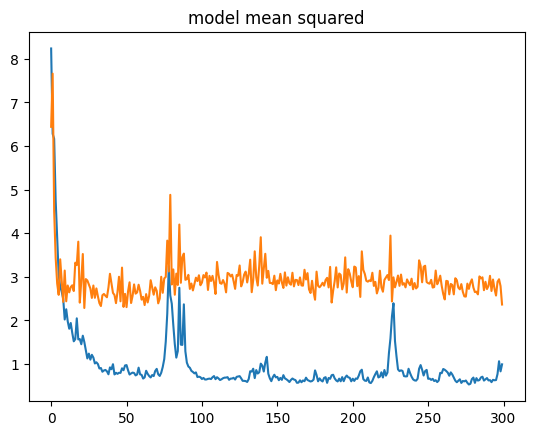

In [22]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mean squared')